In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [38]:

# set the seaborn run command for font parameters
sns.set(rc={'font.weight': 'bold'}, font_scale=1.3)

# Load the data
data = pd.read_csv('../data/crime_data_cleaned.csv')

# remove spaces from column names
data.columns = data.columns.str.replace(' ', '')

# format day month year
data['DATEOCC'] = pd.to_datetime(data['DATEOCC'], format='%Y-%m-%d')

print('This dataset shows {} observations and {} features'.format(data.shape[0], data.shape[1]))

This dataset shows 549861 observations and 37 features


### Analyze Crimes Committed - Year over Year

In [39]:
data.columns

Index(['DR_NO', 'DateRptd', 'DATEOCC', 'TIMEOCC', 'AREA', 'AREANAME',
       'RptDistNo', 'Part1-2', 'CrmCd', 'CrmCdDesc', 'Mocodes', 'VictAge',
       'VictSex', 'VictDescent', 'PremisCd', 'PremisDesc', 'WeaponUsedCd',
       'WeaponDesc', 'Status', 'StatusDesc', 'CrmCd1', 'CrmCd2', 'CrmCd3',
       'CrmCd4', 'LOCATION', 'CrossStreet', 'LAT', 'LON', 'crime_category',
       'YEAR', 'MONTH', 'DAY', 'HOUR', 'TIME_OF_DAY', 'REPORTING_DELAY',
       'crime_type', 'cleared'],
      dtype='object')

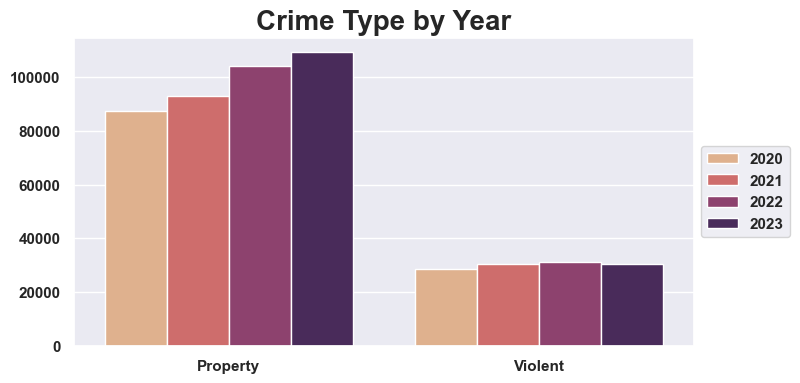

In [40]:
# set plot background
sns.set(style='darkgrid')

# subset data for plotting, Omit 2024 and 'Other' crime type
data = data.loc[
                (data['YEAR']!=2024)& 
                (data['crime_type']!='Other') 
                ]

# plot crime type by year
fig, ax = plt.subplots(figsize=(8, 4))
sns.countplot(x='crime_type', hue='YEAR', data=data, palette='flare')
plt.title('Crime Type by Year', fontsize=20, fontweight='bold')

# move legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('')
plt.ylabel('')

plt.show()


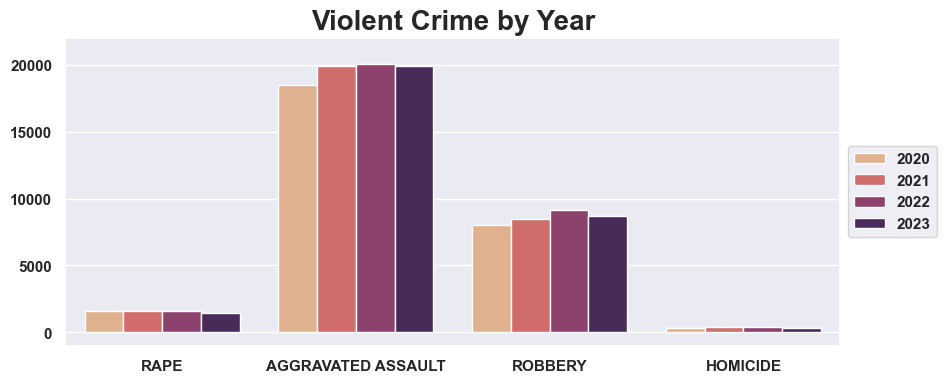

In [41]:
# plot top violent crimes by year
violent_crimes = data[data['crime_type'] == 'Violent']

fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(x='crime_category', hue='YEAR', data=violent_crimes, palette='flare')
plt.title('Violent Crime by Year', fontsize=20, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.ylim(-1000,22000)
# move legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [42]:
# plot the difference in year over year violent crimes
yoy_violent_crimes = violent_crimes.pivot_table(index='crime_category', columns='YEAR', values='CrmCdDesc', aggfunc='count').reset_index()

diff = yoy_violent_crimes.iloc[:,1:5].diff(axis=1).iloc[:,1:5]

rate = yoy_violent_crimes.iloc[:,1:5].pct_change(axis=1).iloc[:,1:5].round(2)

# insert crime_category to position 0 axis 1
rate.insert(0, 'crime_category', yoy_violent_crimes['crime_category'])

rate

YEAR,crime_category,2021,2022,2023
0,AGGRAVATED ASSAULT,0.08,0.01,-0.01
1,HOMICIDE,0.14,-0.02,-0.16
2,RAPE,0.03,-0.02,-0.12
3,ROBBERY,0.06,0.07,-0.05


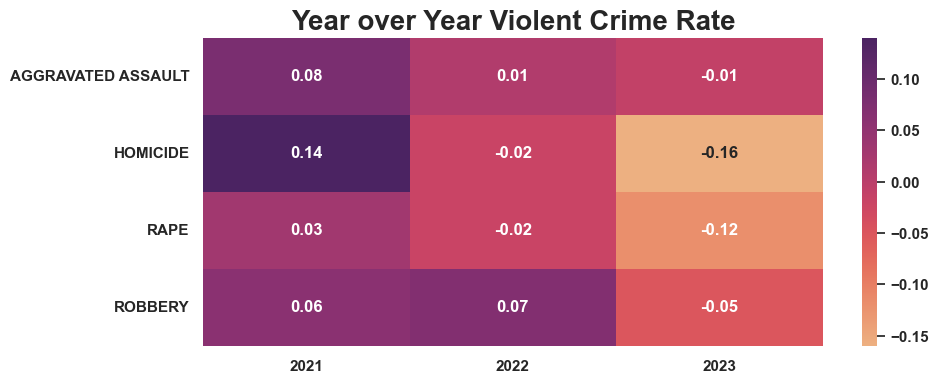

In [43]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(rate.set_index('crime_category'), annot=True, cmap='flare', fmt='g')
plt.title('Year over Year Violent Crime Rate', fontsize=20, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.show()


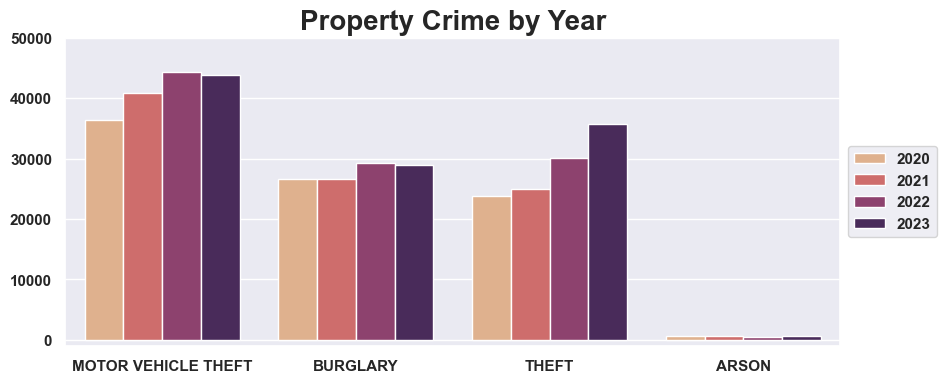

In [44]:
# property crime by year
property_crimes = data[data['crime_type'] == 'Property']

fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(x='crime_category', hue='YEAR', data=property_crimes, palette='flare')
plt.title('Property Crime by Year', fontsize=20, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.ylim(-1000,50000)
# move legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [45]:
# plot the difference in year over year property crimes
yoy_property_crimes = property_crimes.pivot_table(index='crime_category', columns='YEAR', values='CrmCdDesc', aggfunc='count')

diff = yoy_property_crimes.pct_change(axis=1).dropna(axis=1).round(2)

diff

YEAR,2021,2022,2023
crime_category,,,
ARSON,-0.06,-0.15,0.08
BURGLARY,-0.00,0.10,-0.01
MOTOR VEHICLE THEFT,0.12,0.08,-0.01
THEFT,0.05,0.21,0.19


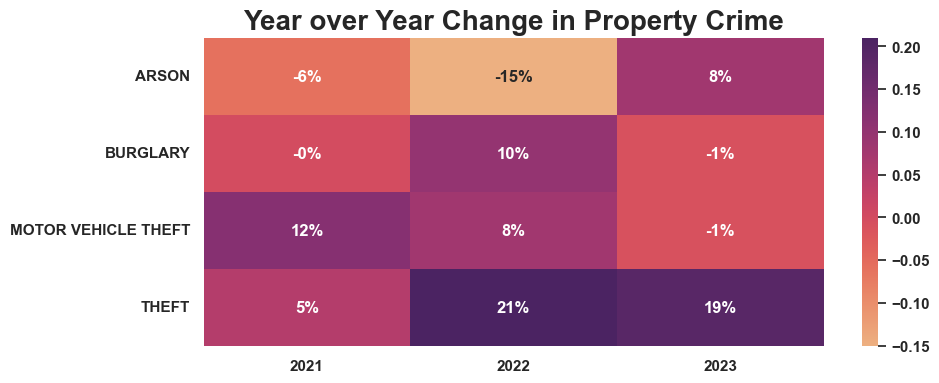

In [46]:
# plot the year over year change in property crime
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(diff, annot=True, fmt=".0%", cmap='flare')
plt.title('Year over Year Change in Property Crime', fontsize=20, fontweight='bold')
plt.xlabel('')
plt.ylabel('')
# show legend

plt.show()


### Now we will look at the crime clearance rates

In [47]:
# subset the data to only include cleared crimes
cleared = data[data['cleared'] == 1]

# group the count of all crimes by year and crime type
crimes = data.groupby(['YEAR','crime_type'])['CrmCdDesc'].count().to_frame().reset_index()

# group the sum of cleared crimes by year and crime type
cleared = data.groupby(['YEAR','crime_type'])['cleared'].sum().to_frame().reset_index()

# merge the cleared and crimes dataframes
rate = cleared.merge(crimes, on=['YEAR','crime_type'], how='left')

# rename the columns
rate = rate.rename(columns={'CrmCdDesc':'total_crimes'})

# calculate the clearance rate
rate['clearance_rate'] = (rate['cleared'] / rate['total_crimes']).round(2)

# subset the columns
rate = rate.loc[:,['YEAR','crime_type','clearance_rate']]
                
rate                

,YEAR,crime_type,clearance_rate
0,2020,Property,0.08
1,2020,Violent,0.43
2,2021,Property,0.07
3,2021,Violent,0.42
4,2022,Property,0.06
5,2022,Violent,0.40
6,2023,Property,0.06
7,2023,Violent,0.37


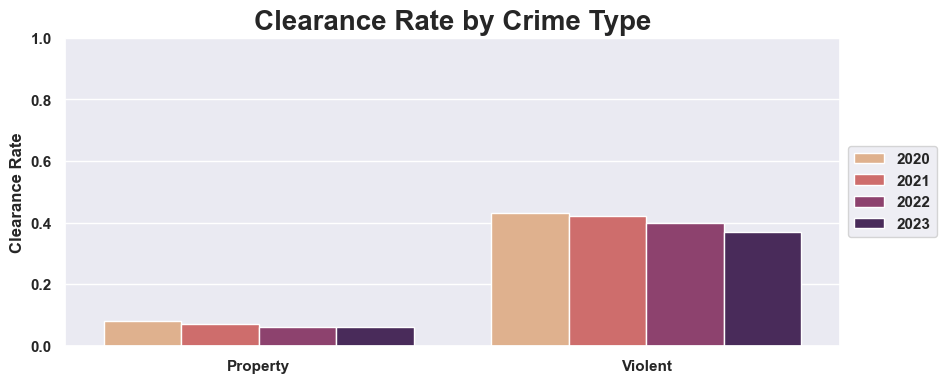

In [51]:
# plot the data
sns.set(style='darkgrid')

fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x='crime_type', y='clearance_rate', hue='YEAR', data=rate, palette='flare')
plt.title('Clearance Rate by Crime Type', fontsize=20, fontweight='bold')
plt.xlabel('')
plt.ylabel('Clearance Rate', fontsize=12, fontweight='bold')
plt.ylim(0,1)
# move legend outside of plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


### Plot the Data

### Create an Interactive Chloropleth Map
These maps are quite challenging to build and there is minimal documentation available.<br>
I found a good tutorial that can serve as a companion, reviewing 3 different types of maps<br>
[Interactive Maps Tutorial](https://medium.com/geekculture/three-ways-to-plot-choropleth-map-using-python-f53799a3e623) <br>

We will use the Folium Python package.  There are 2 steps involved in building this map 
<br>
1.  Acquire the geojson data -  This data serves as the boundaries for the map and is an essential layer, where the data in the geojson file, must match the data in the dataset in the `AREANAME` column.  You can create geojson data, which is quite challenging.  Or you can look to get the file from an existing project.  If you're working on a government dataset, you can find the appropriate geojson data on GitHub <br><br>

2.  Colorscale effect - Create a dataframe with 2 columns, namely `AREANAME` and count of crimes in the region<br>
*Once again - the `AREANAME` must match the geojson data for the map to render correctly*<br>
<br>
Geojson data is widely available on GitHub.<br>


### Get the Geojson Data

In [ ]:
#Import modules for acquiring geojson
from urllib.request import urlopen
import json

#Import geojson from Github
with urlopen('https://raw.githubusercontent.com/sidneykung/LA_crime_forecasting/main/data/LAPD_Divisions.json') as response:
    lapd_divisions = json.load(response)  #Collect geojson data from Github

In [ ]:
#import folium
import folium

#Creaate a map object for choropleth map
#Set location to your location of interest (latitude and longitude )
map0 = folium.Map(location=[34.0549,-118.2426], zoom_start=10)

#Create choropleth map object with key on TOWNNAME
folium.Choropleth(geo_data = lapd_divisions,#Assign geo_data to your geojson file
    name = "choropleth",
    data = plot_theft,#Assign dataset of interest
    columns = ['name','count'],#Assign columns in the dataset for plotting
    key_on = 'feature.properties.name',#Assign the key that geojson uses to connect with dataset
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.5,
    legend_name = 'Count of Crimes by Area').add_to(map0)

#Create style_function
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}

#Create highlight_function
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}

#Create popup tooltip object
NIL = folium.features.GeoJson(
    lapd_divisions,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name'],
        aliases=['Area'],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")))

#Add tooltip object to the map
map0.add_child(NIL)
map0.keep_in_front(NIL)
folium.LayerControl().add_to(map0)

# load the map
map0